In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import libraries

In [2]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.8 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# plt.style.use('dark_background')

from statsmodels.tsa.stattools import adfuller  # kiểm tra chuỗi có tính dừng không -> có phụ thuộc vào thời gian chạy không?
from statsmodels.tsa.seasonal import seasonal_decompose   # phân tích -> thành phần chuỗi gốc, thành phần xu hướng, thành phần mùa vụ và thành phần nhiễu

from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Eval Function

In [4]:
def eval(test,pred,val,pred_val):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  print('\n** Validate **')
  val_mae = mean_absolute_error(val, pred_val)
  print('MAE: ', val_mae)

  val_ape = np.abs((val - pred_val) / val)
  val_mape = np.mean(val_ape) * 100
  print('MAPE: ', val_mape)

  val_mse = mean_squared_error(val, pred_val)
  val_rmse = np.sqrt(val_mse)
  print('RMSE: ', val_rmse)

In [5]:
def test_stationarity(timeseries):

    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='yellow', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC') # tự động lựa chọn số lượng lag tối ưu dựa trên tiêu chí AIC ->
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

## Data

In [6]:
# 2. Đọc file csv
# company_csv = '/content/drive/MyDrive/Colab Notebooks/Datacrawl/IMP.csv'
company_csv = '/content/drive/MyDrive/Colab Notebooks/Datacrawl/OPC.csv'
# company_csv = '/content/drive/MyDrive/Colab Notebooks/Datacrawl/VMD.csv'
data = pd.read_csv(company_csv)
data

,Unnamed: 0,time,open,high,low,close,volume,ticker
0,0,2014-01-02,9910,9910,9850,9850,12650,OPC
1,1,2014-01-03,9150,9910,9150,9910,2160,OPC
2,2,2014-01-06,9450,9850,9450,9850,1090,OPC
3,3,2014-01-07,9850,9850,9850,9850,200,OPC
4,4,2014-01-08,9450,9910,9450,9850,1290,OPC
...,...,...,...,...,...,...,...,...
2463,2463,2023-12-04,22500,22900,22500,22900,15300,OPC
2464,2464,2023-12-05,22900,22900,22900,22900,18500,OPC
2465,2465,2023-12-06,22900,22950,22900,22900,26000,OPC
2466,2466,2023-12-07,22900,22900,22600,22900,19100,OPC


### Choose X

## Train, test, valid

In [7]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 8:1:1
df = pd.read_csv(company_csv)
df = df[['close']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets 8:1:1
train_size = int(0.8 * len(df))
test_size = int(0.1 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [8]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['close'])

## Build model

### Choose p, q, d

In [9]:
model_autoARIMA = auto_arima(y_train,start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=False,
                           d=0, D=0, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True,
                      exogenous= data[['high','open','low']][:len(y_train)])

model_autoARIMA.summary()

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=43754.385, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=28731.687, Time=0.55 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=28684.511, Time=1.36 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.77 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=28700.514, Time=2.92 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=28722.377, Time=2.96 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=28695.896, Time=1.83 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=2.01 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=28685.366, Time=2.97 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=28680.779, Time=4.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=28731.381, Time=1.06 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=28683.3

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1974
Model:               SARIMAX(2, 0, 1)   Log Likelihood              -14335.390
Date:                Sat, 16 Dec 2023   AIC                          28680.779
Time:                        15:16:11   BIC                          28708.718
Sample:                             0   HQIC                         28691.044
                               - 1974                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.5842      8.145      0.317      0.751     -13.380      18.548
ar.L1          1.4964      0.029     50.838      0.000       1.439       1.554
ar.L2         -0.4966      0.029    -16.925      0.000      -0.554      -0.439
ma.L1         -0.7481      0.024    -31.534      0.000      -0.795      -0.702
sigma2      1.179e+05      0.001   7.97e+07      0.000    1.18e+05    1.18e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):              1732.28
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               5.76   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.55e+23. Standard errors may be unstable.
"""

### Build model

In [10]:
model = ARIMA(y_train, order=(2,0,1),exog=data[['high','open','low']][:len(y_train)]).fit()
model.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1974
Model:                 ARIMA(2, 0, 1)   Log Likelihood              -13147.470
Date:                Sat, 16 Dec 2023   AIC                          26310.940
Time:                        15:16:14   BIC                          26355.643
Sample:                             0   HQIC                         26327.365
                               - 1974                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.7186     30.049     -0.057      0.954     -60.613      57.176
high           0.7498      0.011     66.085      0.000       0.728       0.772
open          -0.4366      0.009    -46.172      0.000      -0.455      -0.418
low            0.6873      0.009     78.500      0.000       0.670       0.704
ar.L1          0.9423      0.070     13.437      0.000       0.805       1.080
ar.L2         -0.0378      0.019     -2.023      0.043      -0.074      -0.001
ma.L1         -0.8687      0.069    -12.570      0.000      -1.004      -0.733
sigma2      3.577e+04    555.722     64.362      0.000    3.47e+04    3.69e+04
===================================================================================
Ljung-Box (L1) (Q):                   3.21   Jarque-Bera (JB):              9563.08
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               7.27   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Eval

In [11]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['close'])
y_pred = model.predict(start=int(x_test[0]), end=int(len(x_test)+x_test[0]-1),exog=data[['high','open','low']][int(x_test[0]):int(len(x_test)+x_test[0])])


x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['close'])
y_pred_val =  model.predict(start=int(x_val[0]), end=int(len(x_val)+x_val[0]-1),exog=data[['high','open','low']][len(x_train):(int(len(x_val)+x_val[0]))])

In [12]:
eval(y_test,y_pred,y_val,y_pred_val)

** Testing **
MAE:  142.2760167499905
MAPE:  0.6409944644533098
RMSE:  200.11816224597396

** Validate **
MAE:  120.79550493865729
MAPE:  0.5172156665982175
RMSE:  197.74025236072956


## Forecast

In [13]:
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
# exogg = data[['high','open','low']][last_index-447:last_index].values.reshape(1341, 0)
# 1332 - 444 ; 1341 - 447; 1338 - 446
y_next_30_days = model.predict(start=int(x_next_30_days[0]), end=int(len(x_next_30_days)+x_next_30_days[0]-1),exog= data[['high','open','low']][last_index-524:last_index])
#data[['high','open','low']][last_index-447:last_index]

print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
2468    22259.360483
2469    22649.501245
2470    22959.741305
2471    22537.112546
2472    22859.577794
2473    23059.677663
2474    23009.766272
2475    23009.766272
2476    22821.973887
2477    22875.351845
2478    23009.766272
2479    22721.696799
2480    22909.716338
2481    22909.716338
2482    22909.716338
2483    22915.968015
2484    22859.691371
2485    22731.415044
2486    22634.800396
2487    22678.460109
2488    22840.987352
2489    22640.887484
2490    22709.616470
2491    22722.119823
2492    22771.948919
2493    22696.741104
2494    22809.439251
2495    22909.716338
2496    22947.206669
2497    22703.529381
Name: predicted_mean, dtype: float64


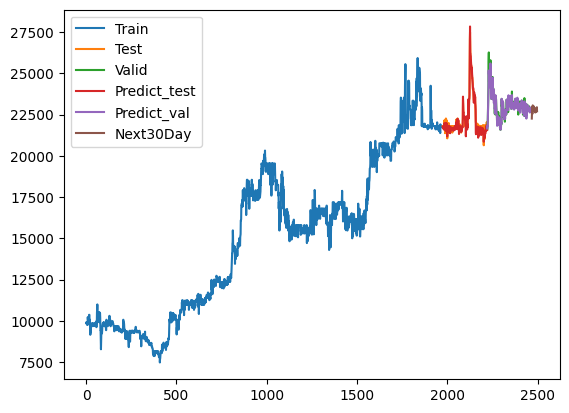

In [14]:
plt.plot(train_data.index, train_data['close'])
plt.plot(test_data.index, test_data['close'])
plt.plot(val_data.index, val_data['close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Valid', 'Predict_test','Predict_val','Next30Day'])
plt.show()